In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch import nn, optim

from utils import load_all_data, squeeze_and_concat, filter_mask_keep_labels, multiclass_dice_loss
from datasets import MultiTissueDataset, MultiTissueDatasetNoisyBkg
from unet_basic import UNetSimple
from train_utils import EarlyStopping

%load_ext autoreload
%autoreload 2

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Selected device: {device}")
print(f'Num available GPUs: ', torch.cuda.device_count())


p = torch.cuda.get_device_properties()
print(f"Device: {p.name} (Memory: {p.total_memory / 1e9:.2f} GB)")

Selected device: cuda
Num available GPUs:  1
Device: NVIDIA TITAN RTX (Memory: 25.19 GB)


In [3]:
# Data import 
DATA_FOLDER = "/scratch/pdiciano/GenAI/ACDC_mine/data/ACDC_tissue_prop"

data = load_all_data(DATA_FOLDER)
data_concat = squeeze_and_concat(data)

In [4]:
print(data.keys())
print(len(data['image']), len(data['multiClassMasks']))

shapes = []

for image in data['multiClassMasks']:
    shapes.append(image.shape)
set(shapes)

assert data_concat['image'].shape[0] == data_concat['multiClassMasks'].shape[0]
assert data_concat['image'].shape[1:] == data_concat['multiClassMasks'].shape[1:]

dict_keys(['image', 'multiClassMasks', 'PD', 'T1', 'T2'])
176 176


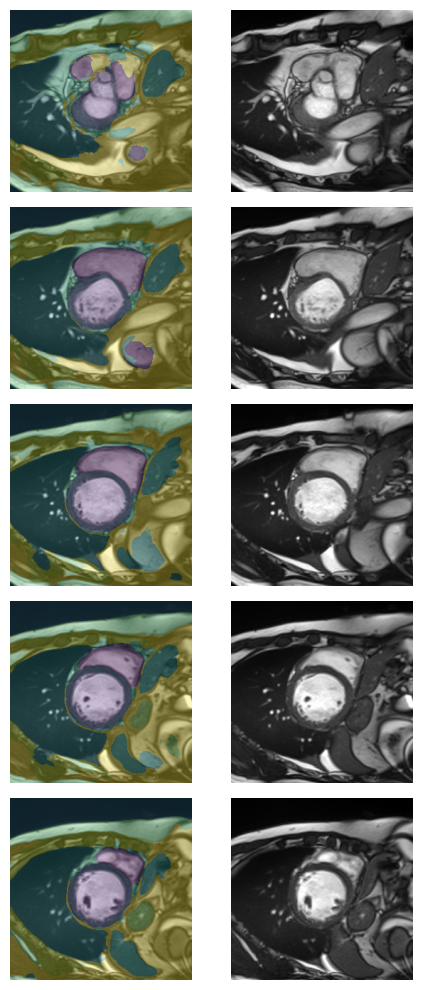

In [5]:
# print overlapping of the two arrays (image and multiClassMasks) to check if they are aligned
vol_idx = np.random.randint(0, len(data_concat['image']))


n_to_show = 5
fig, ax = plt.subplots(n_to_show, 2, figsize=(5, 10))

for i in range(n_to_show):
    img_idx = np.random.randint(0, np.array(shapes)[:,1].min()) # random index for the image slice

    ax[i, 0].imshow(data_concat['image'][i,...], cmap='gray')
    ax[i, 0].imshow(data_concat['multiClassMasks'][i,...], alpha=0.3)

    ax[i, 1].imshow(data_concat['image'][i,...], cmap='gray')

    ax[i,0].axis('off')
    ax[i,1].axis('off')

plt.tight_layout()
plt.show()

In [6]:
np.unique(data_concat['multiClassMasks'][3]), data_concat['multiClassMasks'].shape

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11], dtype=int32),
 (1648, 256, 256))

In [7]:
data_concat_tensor = torch.from_numpy(data_concat['multiClassMasks']).long()

one_hot = torch.nn.functional.one_hot(data_concat_tensor, num_classes=12)
data_concat_onehot = one_hot.permute(0, 3, 1, 2).numpy()

one_hot.shape

torch.Size([1648, 256, 256, 12])

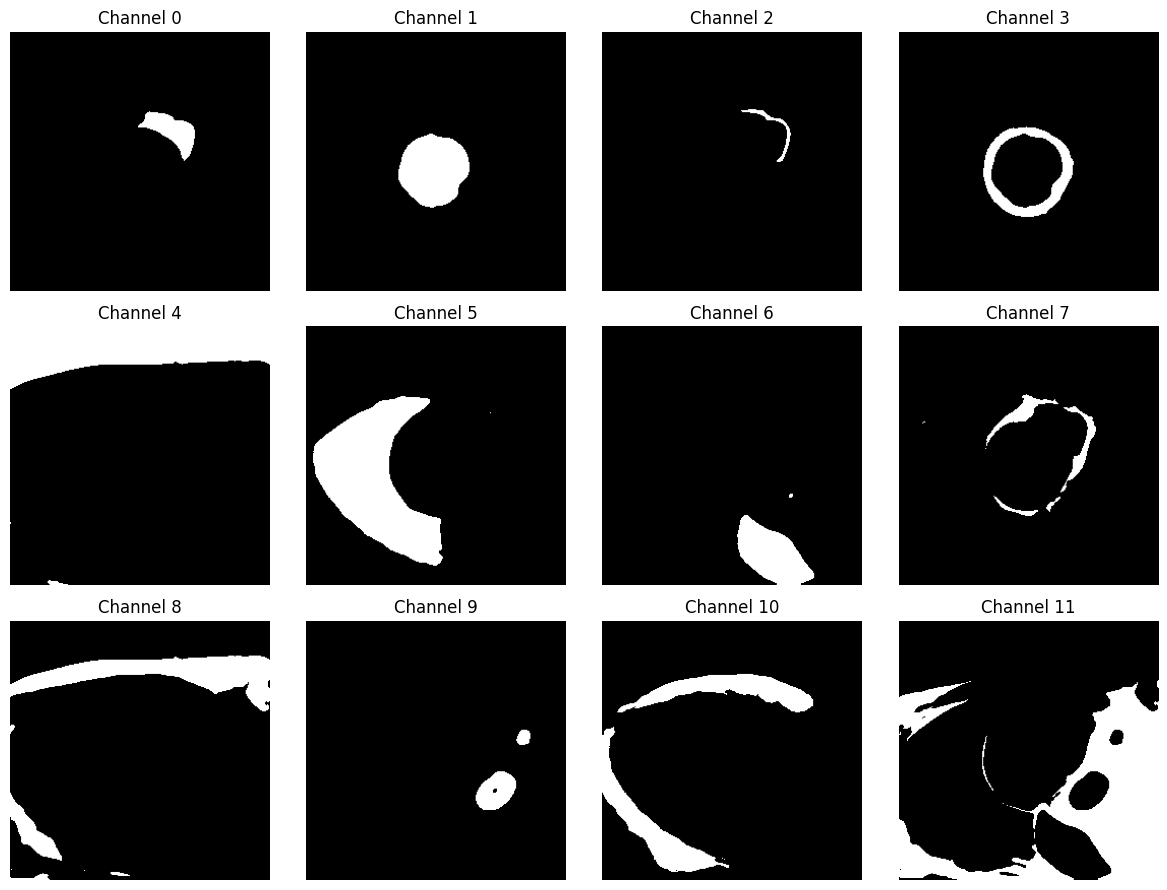

In [8]:
fig, ax = plt.subplots(3, 4, figsize=(12, 9))
ax = ax.flatten()

for i in range(12):
    ax[i].imshow(data_concat_onehot[5, i, ...], cmap='gray')
    ax[i].set_title(f'Channel {i}')
    ax[i].axis('off')

plt.tight_layout()
plt.show()

## Tissue segmentation

Left Myocardium --> label 3 \
Left ventricle --> label 1 \
Right myocardium --> label 2 \
Right ventricle --> label 0 

With "ventricle" meaning the blood pool in the segmentations. \
Based on SAX, the right myocardium is not primarily used to generate the multi-tissue labels, instead it has been generated *together with* the multi-tissue labels.

In this context however we *merge* it with the righ ventricle label (see dataset.py for the implementation)



In [9]:
mask_keep_labels = [0, 1, 2, 3]  # ventricule right, ventricule left, myocardium right, myocardium left

data_concat['input_labels'] = filter_mask_keep_labels(data_concat['multiClassMasks'], mask_keep_labels)

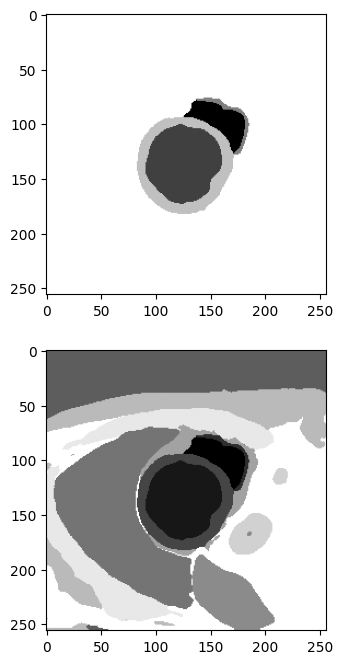

In [10]:
fig, ax = plt.subplots(2, 1, figsize=(8, 8))
ax[0].imshow(data_concat['input_labels'][5], cmap='gray')
ax[1].imshow(data_concat['multiClassMasks'][5], cmap='gray')

True

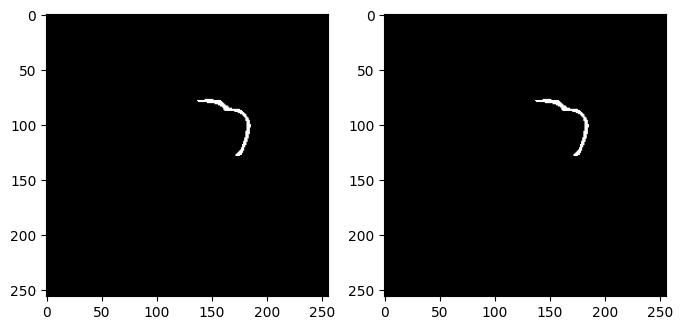

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(8, 8))
ax[0].imshow((data_concat['input_labels'][5]==2).astype(int), cmap='gray')
ax[1].imshow((data_concat['multiClassMasks'][5]==2).astype(int), cmap='gray')

np.array_equal((data_concat['input_labels'][5]==3).astype(int), (data_concat['multiClassMasks'][5]==3).astype(int))

In [12]:
np.unique(data_concat['input_labels'])

array([0, 1, 2, 3, 4], dtype=int32)

unique labels one hot:  [0. 1.]
unique labels after argmax [0 1 2 3]


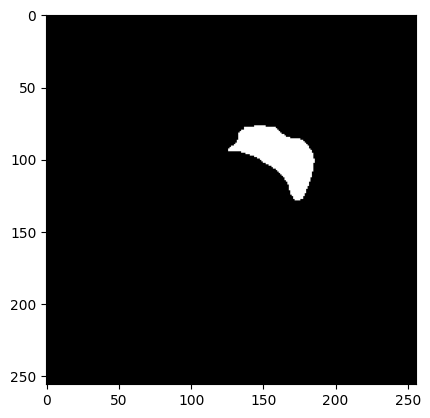

In [13]:
dataset = MultiTissueDataset(data_concat)
plt.imshow(dataset[5]['input_label'][0], cmap='gray')


print('unique labels one hot: ', np.unique(dataset[5]['input_label']))
print('unique labels after argmax', np.unique(torch.argmax(dataset[5]['input_label'], dim=0)))

Merge of right ventricle with right myocardium correctly handled: True


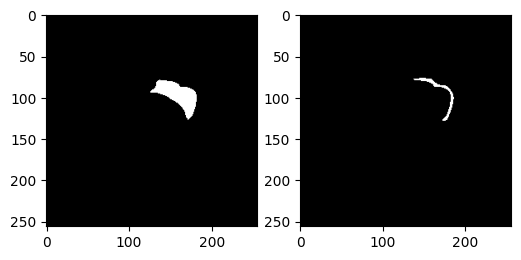

In [14]:
# checks on the merged class (right myocardium)
fig, ax = plt.subplots(1, 2, figsize=(6, 6))

ax[0].imshow((data_concat['multiClassMasks'][5] == 0).astype(int), cmap='gray')
ax[1].imshow((data_concat['multiClassMasks'][5] == 2).astype(int), cmap='gray')

manually_merged = (data_concat['multiClassMasks'][5] == 0).astype(int) + (data_concat['multiClassMasks'][5] == 2).astype(int)
print('Merge of right ventricle with right myocardium correctly handled:', 
      np.array_equal(manually_merged, dataset[5]['input_label'][0] ))

[0 1 2 3]
[ 0  1  2  3  4  5  6  7  8  9 10 11]


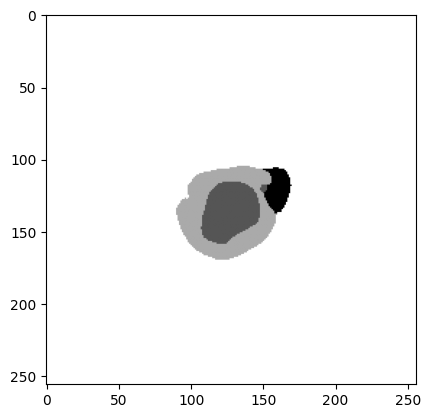

In [15]:
# instantiations and checks on the dataloader
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

batch = next(iter(dataloader))
print(np.unique(torch.argmax(batch['input_label'][7], dim=0)))

batch['input_label'].shape, batch['multiClassMask'].shape
print(np.unique(batch['multiClassMask'][7].numpy()))

plt.imshow(torch.argmax(batch['input_label'][7], dim=0), cmap='gray')

## Training basic UNet

In [16]:
def train(model, dataloader):
    lr = 1e-3
    epochs = 50

    patience = 10
    delta = 0.005

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
    early_stopping = EarlyStopping(patience=patience, delta=delta, verbose=True)

    model.to(device)
    model.train()
    
    metrics = {
        'loss': [],
        'dice_score': []
    }

    for epoch in range(epochs):
        running_loss = 0.0
        n_samples = 0

        with tqdm(dataloader, desc=f"Epoch {epoch+1}") as loop:

            for batch in loop:
                model.train()

                inputs = batch['input_label']  # (B, C, H, W)
                targets = batch['multiClassMask']  # (B, H, W)

                inputs = inputs.to(device)
                targets = targets.to(device)

                outputs = model(inputs) 
                loss = criterion(outputs, targets)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                batch_size = inputs.size(0)
                n_samples += batch_size
                running_loss += loss.item() * batch_size
                current_average_loss = running_loss / n_samples

                loop.set_postfix({'loss: ': f'{current_average_loss:.2f}',
                                'lr: ': f"{optimizer.param_groups[0]['lr']:.2e}"})
        
        scheduler.step()
        dice_score = multiclass_dice_loss(outputs, targets).item()

        metrics['loss'].append(current_average_loss)
        metrics['dice_score'].append(dice_score)

        # Check early stopping condition
        early_stopping.check_early_stop(current_average_loss)
        
        if early_stopping.stop_training:
            print(f"Early stopping at epoch {epoch}")
            break

        print(f"Epoch {epoch+1}/{epochs}, Loss: {current_average_loss:.4f}, Dice Score: {dice_score:.4f}")


    return model, metrics


In [17]:
model = UNetSimple(in_channels=4, num_classes=12, base_channels=32, depth=5, bilinear=False).to(device)

trained_model, metrics = train(model, dataloader)
torch.save(trained_model.state_dict(), './models/gan_texturizer_basic_unet_model.pth')

Epoch 1: 100%|██████████| 103/103 [00:16<00:00,  6.13it/s, loss: =1.56, lr: =1.00e-03]


Epoch 1/50, Loss: 1.5618, Dice Score: 0.6463


Epoch 2: 100%|██████████| 103/103 [00:16<00:00,  6.21it/s, loss: =1.21, lr: =9.76e-04]


Epoch 2/50, Loss: 1.2101, Dice Score: 0.5685


Epoch 3: 100%|██████████| 103/103 [00:16<00:00,  6.20it/s, loss: =1.11, lr: =9.05e-04]


Epoch 3/50, Loss: 1.1056, Dice Score: 0.5245


Epoch 4: 100%|██████████| 103/103 [00:16<00:00,  6.22it/s, loss: =1.06, lr: =7.94e-04]


Epoch 4/50, Loss: 1.0625, Dice Score: 0.4952


Epoch 5: 100%|██████████| 103/103 [00:16<00:00,  6.19it/s, loss: =1.03, lr: =6.55e-04]


Epoch 5/50, Loss: 1.0268, Dice Score: 0.5122


Epoch 6: 100%|██████████| 103/103 [00:16<00:00,  6.23it/s, loss: =0.99, lr: =5.00e-04]


Epoch 6/50, Loss: 0.9900, Dice Score: 0.5249


Epoch 7: 100%|██████████| 103/103 [00:16<00:00,  6.14it/s, loss: =0.97, lr: =3.45e-04]


Epoch 7/50, Loss: 0.9702, Dice Score: 0.4968


Epoch 8: 100%|██████████| 103/103 [00:16<00:00,  6.19it/s, loss: =0.95, lr: =2.06e-04]


Epoch 8/50, Loss: 0.9511, Dice Score: 0.4704


Epoch 9: 100%|██████████| 103/103 [00:16<00:00,  6.19it/s, loss: =0.93, lr: =9.55e-05]


Epoch 9/50, Loss: 0.9308, Dice Score: 0.5054


Epoch 10: 100%|██████████| 103/103 [00:16<00:00,  6.17it/s, loss: =0.92, lr: =2.45e-05]


Epoch 10/50, Loss: 0.9197, Dice Score: 0.4694


Epoch 11: 100%|██████████| 103/103 [00:16<00:00,  6.22it/s, loss: =0.99, lr: =1.00e-03]


Epoch 11/50, Loss: 0.9893, Dice Score: 0.4557


Epoch 12: 100%|██████████| 103/103 [00:16<00:00,  6.22it/s, loss: =0.97, lr: =9.94e-04]


Epoch 12/50, Loss: 0.9735, Dice Score: 0.4885


Epoch 13: 100%|██████████| 103/103 [00:16<00:00,  6.22it/s, loss: =0.96, lr: =9.76e-04]


Epoch 13/50, Loss: 0.9569, Dice Score: 0.4573


Epoch 14: 100%|██████████| 103/103 [00:16<00:00,  6.22it/s, loss: =0.94, lr: =9.46e-04]


Epoch 14/50, Loss: 0.9400, Dice Score: 0.4527


Epoch 15: 100%|██████████| 103/103 [00:16<00:00,  6.22it/s, loss: =0.93, lr: =9.05e-04]


Epoch 15/50, Loss: 0.9288, Dice Score: 0.4517


Epoch 16: 100%|██████████| 103/103 [00:16<00:00,  6.23it/s, loss: =0.91, lr: =8.54e-04]


Epoch 16/50, Loss: 0.9072, Dice Score: 0.4574


Epoch 17: 100%|██████████| 103/103 [00:16<00:00,  6.22it/s, loss: =0.90, lr: =7.94e-04]


Epoch 17/50, Loss: 0.8971, Dice Score: 0.4538


Epoch 18: 100%|██████████| 103/103 [00:16<00:00,  6.21it/s, loss: =0.88, lr: =7.27e-04]


Epoch 18/50, Loss: 0.8806, Dice Score: 0.4489


Epoch 19: 100%|██████████| 103/103 [00:16<00:00,  6.17it/s, loss: =0.86, lr: =6.55e-04]


Epoch 19/50, Loss: 0.8619, Dice Score: 0.4329


Epoch 20: 100%|██████████| 103/103 [00:16<00:00,  6.18it/s, loss: =0.85, lr: =5.78e-04]


Epoch 20/50, Loss: 0.8506, Dice Score: 0.4354


Epoch 21: 100%|██████████| 103/103 [00:16<00:00,  6.19it/s, loss: =0.83, lr: =5.00e-04]


Epoch 21/50, Loss: 0.8282, Dice Score: 0.3940


Epoch 22: 100%|██████████| 103/103 [00:16<00:00,  6.18it/s, loss: =0.81, lr: =4.22e-04]


Epoch 22/50, Loss: 0.8071, Dice Score: 0.4103


Epoch 23: 100%|██████████| 103/103 [00:16<00:00,  6.20it/s, loss: =0.79, lr: =3.45e-04]


Epoch 23/50, Loss: 0.7901, Dice Score: 0.4221


Epoch 24: 100%|██████████| 103/103 [00:16<00:00,  6.15it/s, loss: =0.77, lr: =2.73e-04]


Epoch 24/50, Loss: 0.7689, Dice Score: 0.3929


Epoch 25: 100%|██████████| 103/103 [00:16<00:00,  6.10it/s, loss: =0.75, lr: =2.06e-04]


Epoch 25/50, Loss: 0.7513, Dice Score: 0.3936


Epoch 26: 100%|██████████| 103/103 [00:16<00:00,  6.15it/s, loss: =0.74, lr: =1.46e-04]


Epoch 26/50, Loss: 0.7372, Dice Score: 0.4127


Epoch 27: 100%|██████████| 103/103 [00:16<00:00,  6.20it/s, loss: =0.71, lr: =9.55e-05]


Epoch 27/50, Loss: 0.7147, Dice Score: 0.3833


Epoch 28: 100%|██████████| 103/103 [00:16<00:00,  6.19it/s, loss: =0.70, lr: =5.45e-05]


Epoch 28/50, Loss: 0.7035, Dice Score: 0.4059


Epoch 29: 100%|██████████| 103/103 [00:16<00:00,  6.18it/s, loss: =0.69, lr: =2.45e-05]


Epoch 29/50, Loss: 0.6942, Dice Score: 0.3798


Epoch 30: 100%|██████████| 103/103 [00:16<00:00,  6.18it/s, loss: =0.69, lr: =6.16e-06]


Epoch 30/50, Loss: 0.6889, Dice Score: 0.3981


Epoch 31: 100%|██████████| 103/103 [00:16<00:00,  6.19it/s, loss: =0.82, lr: =1.00e-03]


Epoch 31/50, Loss: 0.8243, Dice Score: 0.4300


Epoch 32: 100%|██████████| 103/103 [00:16<00:00,  6.17it/s, loss: =0.79, lr: =9.98e-04]


Epoch 32/50, Loss: 0.7910, Dice Score: 0.4275


Epoch 33: 100%|██████████| 103/103 [00:16<00:00,  6.12it/s, loss: =0.79, lr: =9.94e-04]


Epoch 33/50, Loss: 0.7882, Dice Score: 0.4367


Epoch 34: 100%|██████████| 103/103 [00:16<00:00,  6.14it/s, loss: =0.77, lr: =9.86e-04]


Epoch 34/50, Loss: 0.7722, Dice Score: 0.4078


Epoch 35: 100%|██████████| 103/103 [00:16<00:00,  6.15it/s, loss: =0.75, lr: =9.76e-04]


Epoch 35/50, Loss: 0.7527, Dice Score: 0.4239


Epoch 36: 100%|██████████| 103/103 [00:16<00:00,  6.15it/s, loss: =0.73, lr: =9.62e-04]


Epoch 36/50, Loss: 0.7335, Dice Score: 0.3693


Epoch 37: 100%|██████████| 103/103 [00:16<00:00,  6.13it/s, loss: =0.72, lr: =9.46e-04]


Epoch 37/50, Loss: 0.7233, Dice Score: 0.3763


Epoch 38: 100%|██████████| 103/103 [00:16<00:00,  6.20it/s, loss: =0.69, lr: =9.26e-04]


Epoch 38/50, Loss: 0.6933, Dice Score: 0.3726


Epoch 39: 100%|██████████| 103/103 [00:16<00:00,  6.18it/s, loss: =0.69, lr: =9.05e-04]


Epoch 39/50, Loss: 0.6904, Dice Score: 0.3512


Epoch 40: 100%|██████████| 103/103 [00:16<00:00,  6.23it/s, loss: =0.67, lr: =8.80e-04]


Epoch 40/50, Loss: 0.6712, Dice Score: 0.3726


Epoch 41: 100%|██████████| 103/103 [00:16<00:00,  6.18it/s, loss: =0.66, lr: =8.54e-04]


Epoch 41/50, Loss: 0.6570, Dice Score: 0.3808


Epoch 42: 100%|██████████| 103/103 [00:16<00:00,  6.15it/s, loss: =0.62, lr: =8.25e-04]


Epoch 42/50, Loss: 0.6222, Dice Score: 0.3536


Epoch 43: 100%|██████████| 103/103 [00:16<00:00,  6.13it/s, loss: =0.60, lr: =7.94e-04]


Epoch 43/50, Loss: 0.6049, Dice Score: 0.3563


Epoch 44: 100%|██████████| 103/103 [00:16<00:00,  6.21it/s, loss: =0.59, lr: =7.61e-04]


Epoch 44/50, Loss: 0.5946, Dice Score: 0.3299


Epoch 45: 100%|██████████| 103/103 [00:16<00:00,  6.20it/s, loss: =0.57, lr: =7.27e-04]


Epoch 45/50, Loss: 0.5683, Dice Score: 0.3581


Epoch 46: 100%|██████████| 103/103 [00:16<00:00,  6.19it/s, loss: =0.56, lr: =6.91e-04]


Epoch 46/50, Loss: 0.5555, Dice Score: 0.3334


Epoch 47: 100%|██████████| 103/103 [00:16<00:00,  6.19it/s, loss: =0.54, lr: =6.55e-04]


Epoch 47/50, Loss: 0.5402, Dice Score: 0.3357


Epoch 48: 100%|██████████| 103/103 [00:16<00:00,  6.19it/s, loss: =0.52, lr: =6.17e-04]


Epoch 48/50, Loss: 0.5158, Dice Score: 0.2982


Epoch 49: 100%|██████████| 103/103 [00:16<00:00,  6.20it/s, loss: =0.50, lr: =5.78e-04]


Epoch 49/50, Loss: 0.4961, Dice Score: 0.2998


Epoch 50: 100%|██████████| 103/103 [00:16<00:00,  6.12it/s, loss: =0.47, lr: =5.39e-04]


Epoch 50/50, Loss: 0.4746, Dice Score: 0.3014


In [18]:
# Basic evaluation on the training set
state_dict = torch.load("./models/gan_texturizer_basic_unet_model.pth")
model.load_state_dict(state_dict)

model.eval()
with torch.no_grad():
    output = model(dataset[5]['input_label'].unsqueeze(0).to(device))
    pred_mask = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()

    output_batch = model(batch['input_label'].to(device))
    pred_mask_batch = torch.argmax(output_batch, dim=1).cpu().numpy()

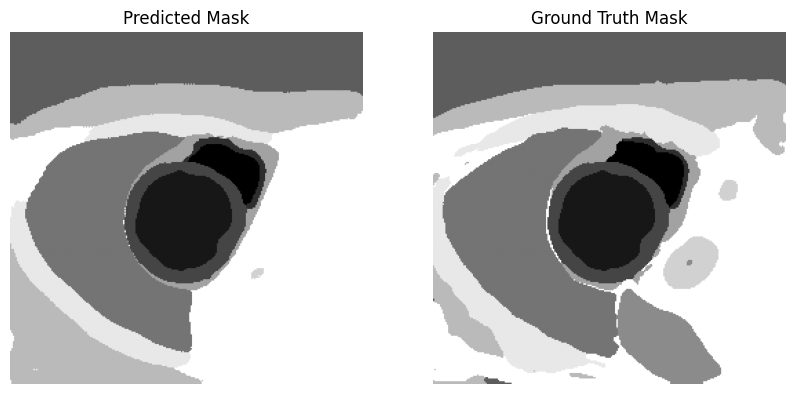

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(pred_mask, cmap='gray')
ax[0].set_title('Predicted Mask')
ax[1].imshow(data_concat['multiClassMasks'][5], cmap='gray')
ax[1].set_title('Ground Truth Mask')

ax[0].axis('off')
ax[1].axis('off')
plt.show()

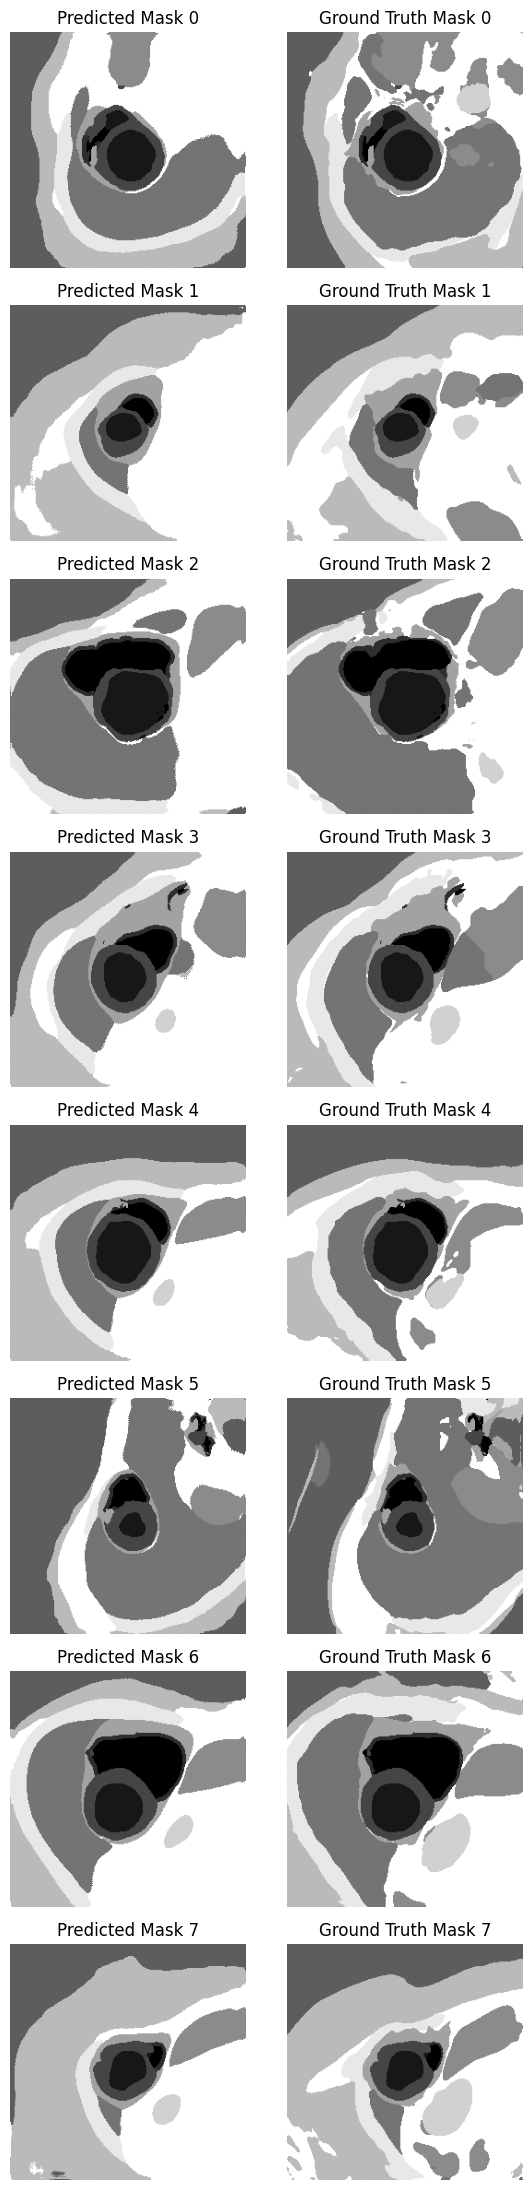

In [20]:
# Show all predicted batch
batch_size = pred_mask_batch.shape[0] // 2
fig, axes = plt.subplots(batch_size, 2, figsize=(6, 22))
for i in range(batch_size):
    axes[i, 0].imshow(pred_mask_batch[i], cmap='gray')
    axes[i, 0].set_title(f'Predicted Mask {i}')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(batch['multiClassMask'][i].cpu().numpy(), cmap='gray')
    axes[i, 1].set_title(f'Ground Truth Mask {i}')
    axes[i, 1].axis('off')
plt.tight_layout()
plt.show()

## Training basic UNet 2
Adding gaussian noise to the background

In [21]:
noise_dataset = MultiTissueDatasetNoisyBkg(data_concat)
noise_dataloader = DataLoader(noise_dataset, batch_size=16, shuffle=True)

In [ ]:
model2 = UNetSimple(in_channels=4, num_classes=12, base_channels=32, depth=5, bilinear=False).to(device)

trained_model2, metrics2 = train(model2, noise_dataloader)
torch.save(trained_model2.state_dict(), './models/gan_texturizer_basic_unet_noisybkg_model.pth')

Epoch 1: 100%|██████████| 103/103 [00:36<00:00,  2.79it/s, loss: =1.63, lr: =1.00e-03]


Epoch 1/50, Loss: 1.6299, Dice Score: 0.6795


Epoch 2: 100%|██████████| 103/103 [00:37<00:00,  2.78it/s, loss: =1.23, lr: =9.76e-04]


Epoch 2/50, Loss: 1.2258, Dice Score: 0.5878


Epoch 3: 100%|██████████| 103/103 [00:36<00:00,  2.80it/s, loss: =1.13, lr: =9.05e-04]


Epoch 3/50, Loss: 1.1256, Dice Score: 0.5494


Epoch 4: 100%|██████████| 103/103 [00:36<00:00,  2.80it/s, loss: =1.06, lr: =7.94e-04]


Epoch 4/50, Loss: 1.0644, Dice Score: 0.5012


Epoch 5: 100%|██████████| 103/103 [00:36<00:00,  2.80it/s, loss: =1.03, lr: =6.55e-04]


Epoch 5/50, Loss: 1.0302, Dice Score: 0.5115


Epoch 6: 100%|██████████| 103/103 [00:37<00:00,  2.78it/s, loss: =1.01, lr: =5.00e-04]


Epoch 6/50, Loss: 1.0060, Dice Score: 0.5150


Epoch 7: 100%|██████████| 103/103 [00:36<00:00,  2.79it/s, loss: =0.98, lr: =3.45e-04]


Epoch 7/50, Loss: 0.9836, Dice Score: 0.4818


Epoch 8: 100%|██████████| 103/103 [00:36<00:00,  2.79it/s, loss: =0.96, lr: =2.06e-04]


Epoch 8/50, Loss: 0.9560, Dice Score: 0.5341


Epoch 9: 100%|██████████| 103/103 [00:37<00:00,  2.77it/s, loss: =0.94, lr: =9.55e-05]


Epoch 9/50, Loss: 0.9371, Dice Score: 0.5076


Epoch 10: 100%|██████████| 103/103 [00:37<00:00,  2.77it/s, loss: =0.93, lr: =2.45e-05]


Epoch 10/50, Loss: 0.9266, Dice Score: 0.5209


Epoch 11: 100%|██████████| 103/103 [00:36<00:00,  2.80it/s, loss: =0.99, lr: =1.00e-03]


Epoch 11/50, Loss: 0.9928, Dice Score: 0.5104


Epoch 12: 100%|██████████| 103/103 [00:37<00:00,  2.77it/s, loss: =0.97, lr: =9.94e-04]


Epoch 12/50, Loss: 0.9750, Dice Score: 0.5025


Epoch 13: 100%|██████████| 103/103 [00:36<00:00,  2.80it/s, loss: =0.97, lr: =9.76e-04]


Epoch 13/50, Loss: 0.9691, Dice Score: 0.5000


Epoch 14: 100%|██████████| 103/103 [00:36<00:00,  2.80it/s, loss: =0.94, lr: =9.46e-04]


Epoch 14/50, Loss: 0.9429, Dice Score: 0.5236


Epoch 15: 100%|██████████| 103/103 [00:36<00:00,  2.79it/s, loss: =0.93, lr: =9.05e-04]


Epoch 15/50, Loss: 0.9312, Dice Score: 0.4785


Epoch 16: 100%|██████████| 103/103 [00:36<00:00,  2.78it/s, loss: =0.91, lr: =8.54e-04]


Epoch 16/50, Loss: 0.9149, Dice Score: 0.4695


Epoch 17:  61%|██████    | 63/103 [00:22<00:14,  2.76it/s, loss: =0.90, lr: =7.94e-04]

In [ ]:
# Basic evaluation on the training set
state_dict = torch.load("./models/gan_texturizer_basic_unet_noisybkg_model.pth")
model2.load_state_dict(state_dict)

model2.eval()
with torch.no_grad():
    output2 = model2(dataset[5]['input_label'].unsqueeze(0).to(device))
    pred_mask2 = torch.argmax(output2, dim=1).squeeze(0).cpu().numpy()

    output_batch2 = model2(batch['input_label'].to(device))
    pred_mask_batch2 = torch.argmax(output_batch2, dim=1).cpu().numpy()

Text(0.5, 1.0, 'Ground Truth Mask')

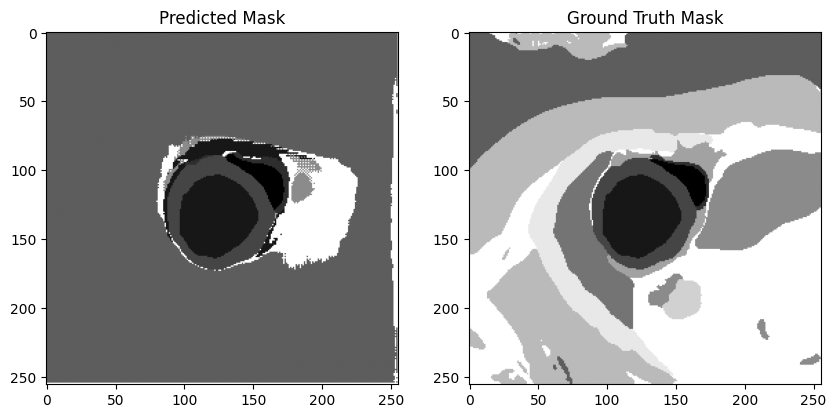

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(pred_mask2, cmap='gray')
ax[0].set_title('Predicted Mask')
ax[1].imshow(data_concat['multiClassMasks'][5], cmap='gray')
ax[1].set_title('Ground Truth Mask')

In [ ]:
# Show all predicted batch
batch_size = pred_mask_batch2.shape[0] // 2
fig, axes = plt.subplots(batch_size, 2, figsize=(6, 22))
for i in range(batch_size):
    axes[i, 0].imshow(pred_mask_batch2[i], cmap='gray')
    axes[i, 0].set_title(f'Predicted Mask {i}')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(batch['multiClassMask'][i].cpu().numpy(), cmap='gray')
    axes[i, 1].set_title(f'Ground Truth Mask {i}')
    axes[i, 1].axis('off')
plt.tight_layout()
plt.show()

NameError: name 'pred_mask_batch2' is not defined

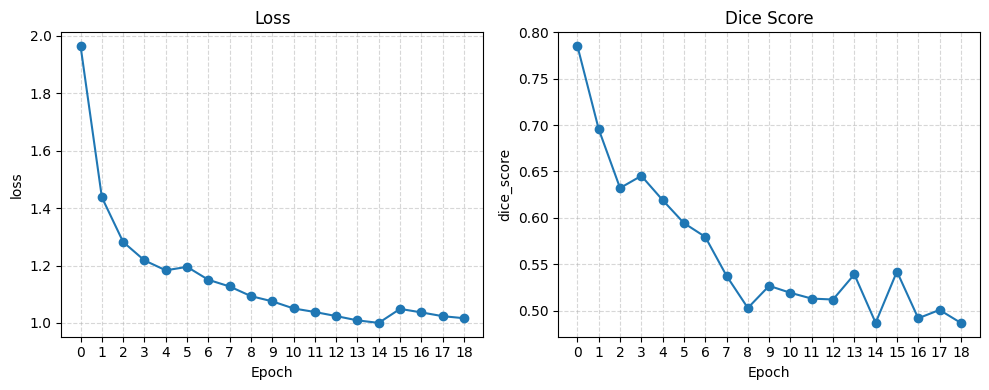

In [ ]:
# for metrics 1
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True)

for ax, (key, values) in zip(axes, metrics.items()):
    # ax.plot(values, marker='o')
    ax.set_title(key.replace('_', ' ').title())
    ax.set_xlabel('Epoch')
    ax.set_ylabel(key)
    ax.set_xticks(range(len(values)))
    ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

NameError: name 'metrics2' is not defined

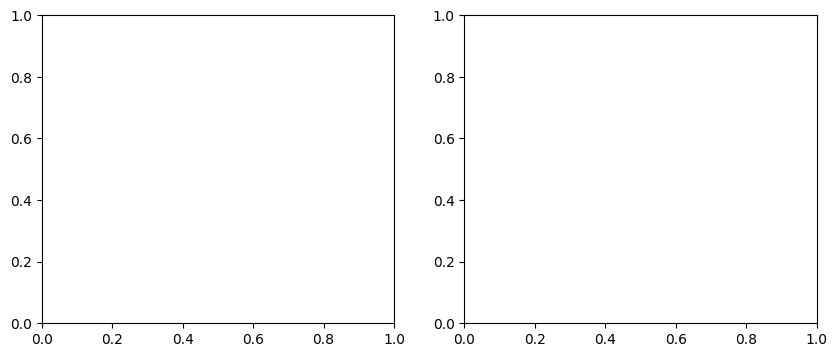

In [ ]:
# for metrics 2
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True)
for ax, (key, values) in zip(axes, metrics2.items()):
    # ax.plot(values, marker='o')
    ax.set_title(key.replace('_', ' ').title())
    ax.set_xlabel('Epoch')
    ax.set_ylabel(key)
    ax.set_xticks(range(len(values)))
    ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()